In [1]:
# we need a max intensity projection to see how the 3D data looks like!

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math

import pylattice.functions.TiffProcessing as pyl

Generate particle images and microscopy images
----------
**Simulation setup / Ground truth**: 
* xyz Area of 50,000 x 50,000 x 50,000 nanometers.
* 1000 particles.
* remember: in tiff files, the first dimension is z!


In [2]:
def simulate_particles(N=1000, size=50000, kamp=0.5, Damp=0.01 ):
    """ Simulate particles
    
    Parameters
    ----------
    N : number of particles
    size : xyz size in nanometers
    Damp : amplitude random component
    kamp : amplitude constant component
    
    """
    X = np.zeros((1, N, 3))  # particle-index, xyz
    A = np.zeros((1, N))
    # initialize
    X[0] = size * np.random.rand(N, 3)
    # simulate

    i = 0
    # constrain to bounding box
    X[i] = X[i] % size
    
    # update amplitudes
    A[i] = kamp + Damp * np.random.randn(N)

    # constrain to [0, 1]
    A[i] = np.absolute(A[i])
    A[i] = np.maximum(np.minimum(A[i], 1.0), 0.0)

    
    return X, A

In [3]:
def simulate_one_particle(N=1, size=2000, kamp=0.5, Damp=0.01 ):
    """ Simulate particles
    
    Parameters
    ----------
    N : number of particles
    size : xyz size in nanometers
    Damp : amplitude random component
    kamp : amplitude constant component
    
    """
    X = np.zeros((1, N, 3))  # particle-index, xyz
    A = np.zeros((1, N))
    # initialize
    X[0] = 1500,1500,1500
    # simulate

    i = 0
    # constrain to bounding box
    X[i] = X[i] % size
    
    # update amplitudes
    A[i] = kamp + Damp * np.random.randn(N)

    # constrain to [0, 1]
    A[i] = np.absolute(A[i])
    A[i] = np.maximum(np.minimum(A[i], 1.0), 0.0)

    
    return X, A

In [4]:
# relationship between resolution (FWHM) and sigma
standard_resolution = 100 #nm
#const = 2
const = 5
standard_sigma = const*standard_resolution / (2.0 * np.sqrt(2*np.log(2)))
standard_sigma_z = 2*standard_sigma
print("standard_sigma {}".format(standard_sigma))
print("standard_sigma_z {}".format(standard_sigma_z))

standard_sigma 212.33045007200477
standard_sigma_z 424.66090014400953


In [5]:
img_signal = np.array([1,1,1])
img_noisySignal = np.array([0,2,-1])
mse = np.mean( (img_signal - img_noisySignal) ** 2 )
print(mse)

2.0


In [6]:
def microscope(trajs_X, trajs_A, 
               size=np.array([5000,5000,5000]), 
               gridsize=np.array([200,100,100]), 
               psf_width=np.array([standard_sigma,standard_sigma,standard_sigma_z]), 
               noise_mean=0.0, noise_sigma=0.1):
    """ Simulate a microscope images given a set of particles
    
    Parameters
    ----------
    trajs : numpy array (1 x N x 3)
        N particle in 3D
    size : float
        Microscope image size, in nanometers
    gridsize : float
        xyz-Size of one microscope pixel, in nanometers
    psf_width : float
        width of the point spread function, in nanometers
    noise : float
        Shot noise intensity

    
    """
    
    # make grid
    _, N, _ = trajs_X.shape
    
    ngrid = (size / gridsize).astype(int)
    c_grid_x = np.linspace(0, size[0]-gridsize[0], num=ngrid[0]) + 0.5*gridsize[0]
    c_grid_y = np.linspace(0, size[1]-gridsize[1], num=ngrid[1]) + 0.5*gridsize[1]
    c_grid_z = np.linspace(0, size[2]-gridsize[2], num=ngrid[2]) + 0.5*gridsize[2]
    
    n_neighbors_x = int(3 * psf_width[0] / gridsize[0]) + 1
    n_neighbors_y = int(3 * psf_width[1] / gridsize[1]) + 1
    n_neighbors_z = int(3 * psf_width[2] / gridsize[2]) + 1
    
    print("ngrid {}".format(ngrid))
    X = np.zeros((1, ngrid[0], ngrid[1], ngrid[2]))
    
    # spread on grid
    t=0
    for i in range(N):
        # find central grid cell
        ix = int((trajs_X[t, i, 0] / size[0]) * ngrid[0])
        iy = int((trajs_X[t, i, 1] / size[1]) * ngrid[1])
        iz = int((trajs_X[t, i, 2] / size[2]) * ngrid[2])
        # iterate over valid neighbors
        #print(i)
        for kx in range(max(0, ix - n_neighbors_x), min(ngrid[0], ix + n_neighbors_x)):
            for ky in range(max(0, iy - n_neighbors_y), min(ngrid[1], iy + n_neighbors_y)):
                for kz in range(max(0, iz - n_neighbors_z), min(ngrid[2], iz + n_neighbors_z)):

                    d2_x = (trajs_X[t, i, 0] - c_grid_x[kx])**2
                    d2_y = (trajs_X[t, i, 1] - c_grid_y[ky])**2
                    d2_z = (trajs_X[t, i, 2] - c_grid_z[kz])**2
                    
                    value = trajs_A[t, i] * np.exp(-d2_x / (2*psf_width[0]*psf_width[0])) \
                                          * np.exp(-d2_y / (2*psf_width[1]*psf_width[1])) \
                                          * np.exp(-d2_z / (2*psf_width[2]*psf_width[2]))                        
                    
                    X[t, kx, ky, kz] += value

                    
    #sigma_signal = np.std(X)                
    # add noise
    # get a sample from a normal distribution
    # noise mean = µ
    # noise sigma = standard deviation
    noise = noise_mean + noise_sigma * np.random.randn(1, ngrid[0], ngrid[1], ngrid[2])
    noise = np.maximum(np.minimum(noise, 1.0), 0.0)
    sigma_noise = np.std(noise)
    #print("SNR signal/noise = {}/{}={}".format(sigma_signal,sigma_noise,sigma_signal/sigma_noise))
    
    
    img_signal = np.copy(X[0])
    

    
    X += noise
    X = np.maximum(np.minimum(X, 1.0), 0.0)
    
    img_noisySignal = np.copy(X[0])
    
    print("### ----- signal plot")
    pyl.maxIntensityProjection(img_signal)
    plt.plot(np.mean(img_signal,axis=0));
    plt.show()
    print("### ----- noisy signal plot")
    pyl.maxIntensityProjection(img_noisySignal)
    plt.plot(np.mean(img_noisySignal,axis=0));
        
    PSNR = psnr(img_signal,img_noisySignal)
    print("PSNR = {:.10f}".format(PSNR))
    
    return [img_signal,noise[0],img_noisySignal]

# simulate

In [7]:
def snr(sigma_full_image,sigma_noise_only):
    return np.sqrt((sigma_full_image*sigma_full_image)/(sigma_noise_only*sigma_noise_only)-1)


In [8]:
#aguet et al 2013
def psnr(img_signal, img_noisySignal,PIXEL_MAX=1):
    
    
    mse = np.mean( (img_signal - img_noisySignal) ** 2 )
#    print(img_signal - img_noisySignal)
    print("MSE = {}".format(mse))
    
    
    if mse == 0:
        return 100
    else:
        

#        return (PIXEL_MAX**2 / mse)
        
        #print("np.max(img_signal)**2 {}".format(np.max(img_signal)**2))
        #return (np.max(img_signal)**2 / mse)
        
        # matlab definition
        # https://www.mathworks.com/help/images/ref/psnr.html#bt5uhgi-1-peaksnr
        #return 10 * math.log10(PIXEL_MAX**2 / mse)
        #return  math.log10(np.max(img_signal)**2 / mse)
        return  np.max(img_signal)**2 / mse
        #return (PIXEL_MAX**2 / mse)
        print("gammel 6")
        #return 10 * math.log10(np.max(img_signal)**2 / mse)
        #return np.max(img_signal)**2 / mse
    
    
    
    

ngrid [250 500 500]
### ----- signal plot


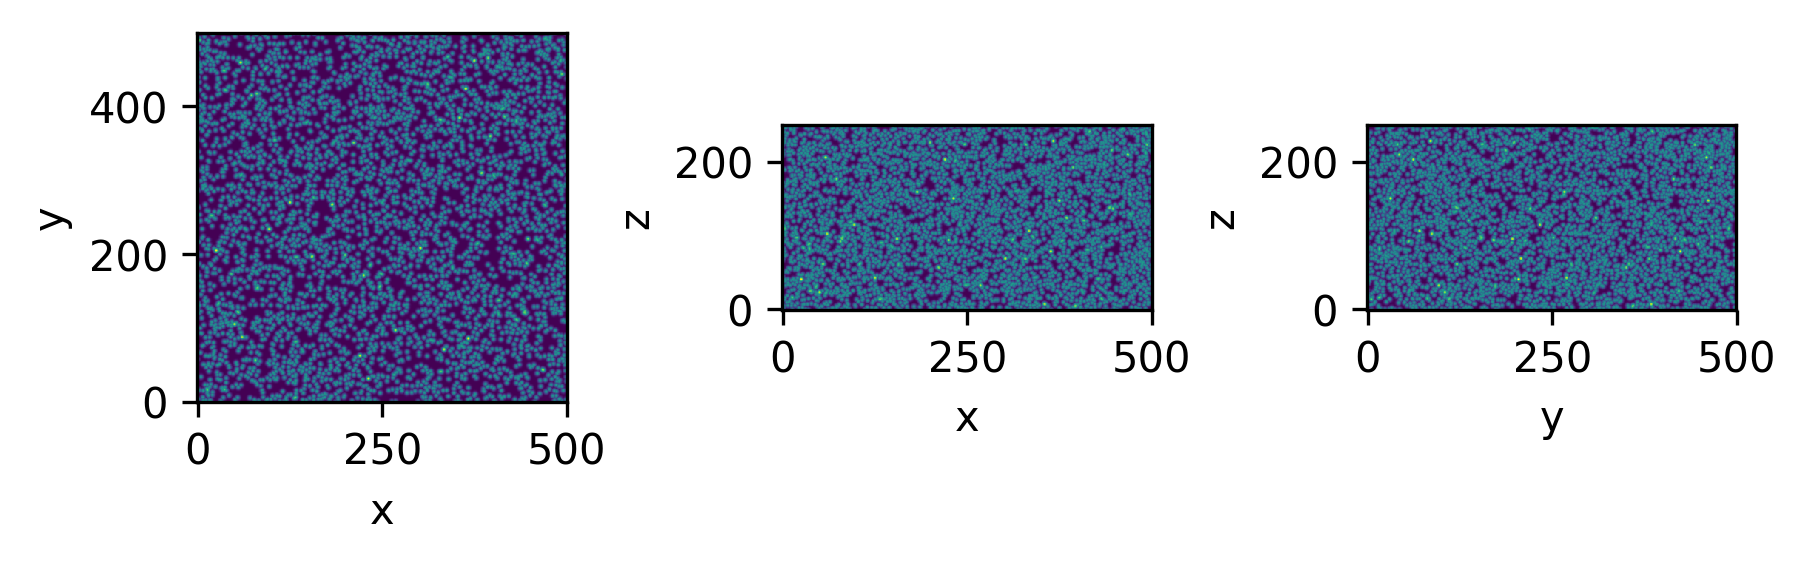

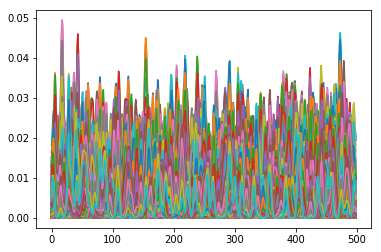

### ----- noisy signal plot


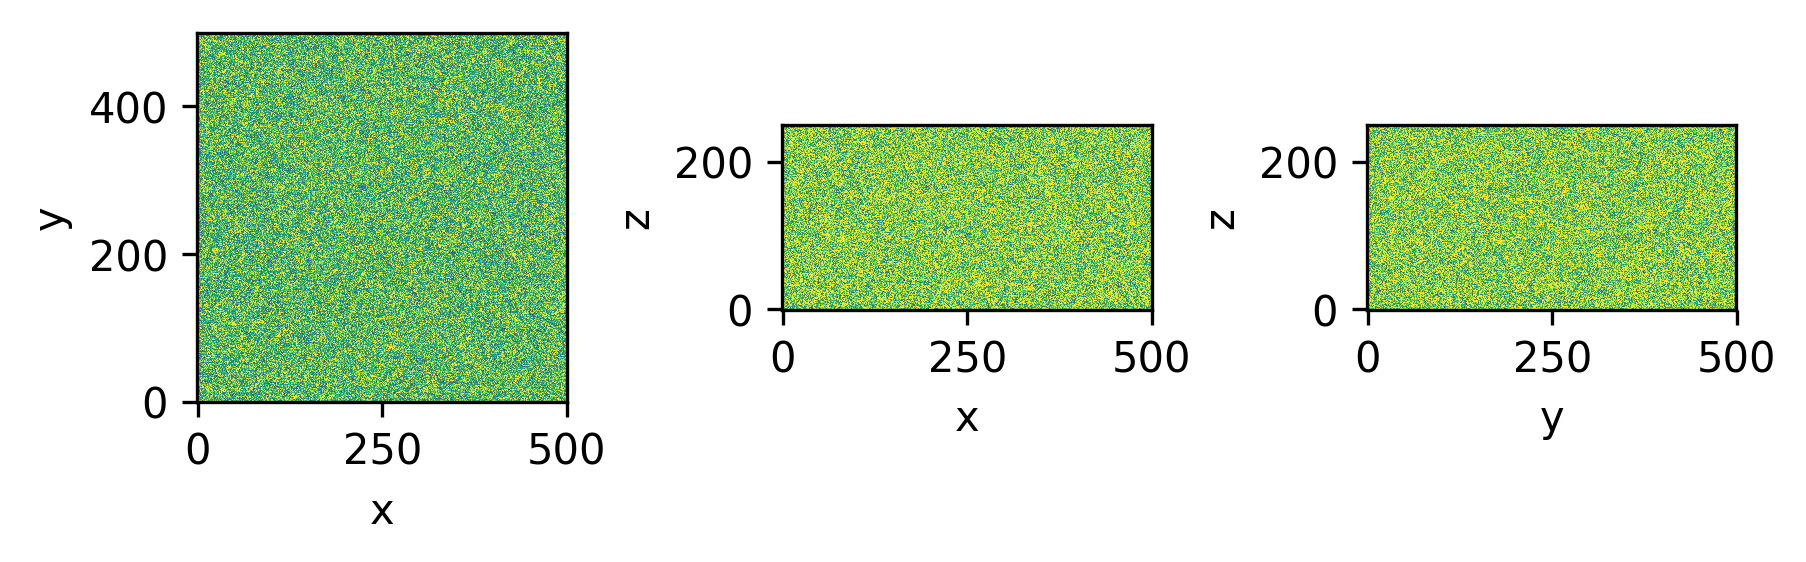

MSE = 0.044929018497680114
PSNR = 20.0672652499
sigma_full_image 0.17656176156053535
scope_noise_sigma 0.3
########## 255 #######
MSE = 2921.5094278116585
PSNR = 20.0672652499


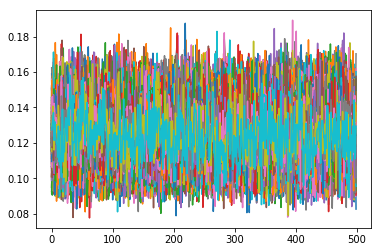

In [23]:
imageSize = np.array([50000,50000,50000]) #50µm cube
scope_resolution = np.array([200,100,100]) #100nm xy, 200z resolution
scope_psf_width = np.array([standard_sigma_z,standard_sigma,standard_sigma])

particle_Damp=0.0001

particle_kamp=0.5

#scope_noise_sigma = 0.4 #PSNR = 3
scope_noise_sigma = 0.3 #PSNR = 5
#scope_noise_sigma = 0.2 #PSNR = 10
#scope_noise_sigma = 0.065 # PSNR = 100 
#scope_noise_sigma = 0.01 # PSNR = 100 something higher...
scope_noise_mean = 0.0


numberOfParticles = 5000

trajs_X, trajs_A = simulate_particles(N=numberOfParticles, size=imageSize,Damp=particle_Damp, kamp=particle_kamp)

S,N,X = microscope(trajs_X, trajs_A, size=imageSize, 
               gridsize=scope_resolution, psf_width=scope_psf_width, noise_mean=scope_noise_mean, noise_sigma=scope_noise_sigma)


#pyl.maxIntensityProjection(X[0])

sigma_full_image = np.std(X[0])
print("sigma_full_image {}".format(sigma_full_image))

print("scope_noise_sigma {}".format(scope_noise_sigma))


print("########## 255 #######")

PSNR = psnr(S*255,X*255,PIXEL_MAX=255)
print("PSNR = {:.10f}".format(PSNR))




0.12299167458178424
(250, 500, 500)
average mask 0.005366832


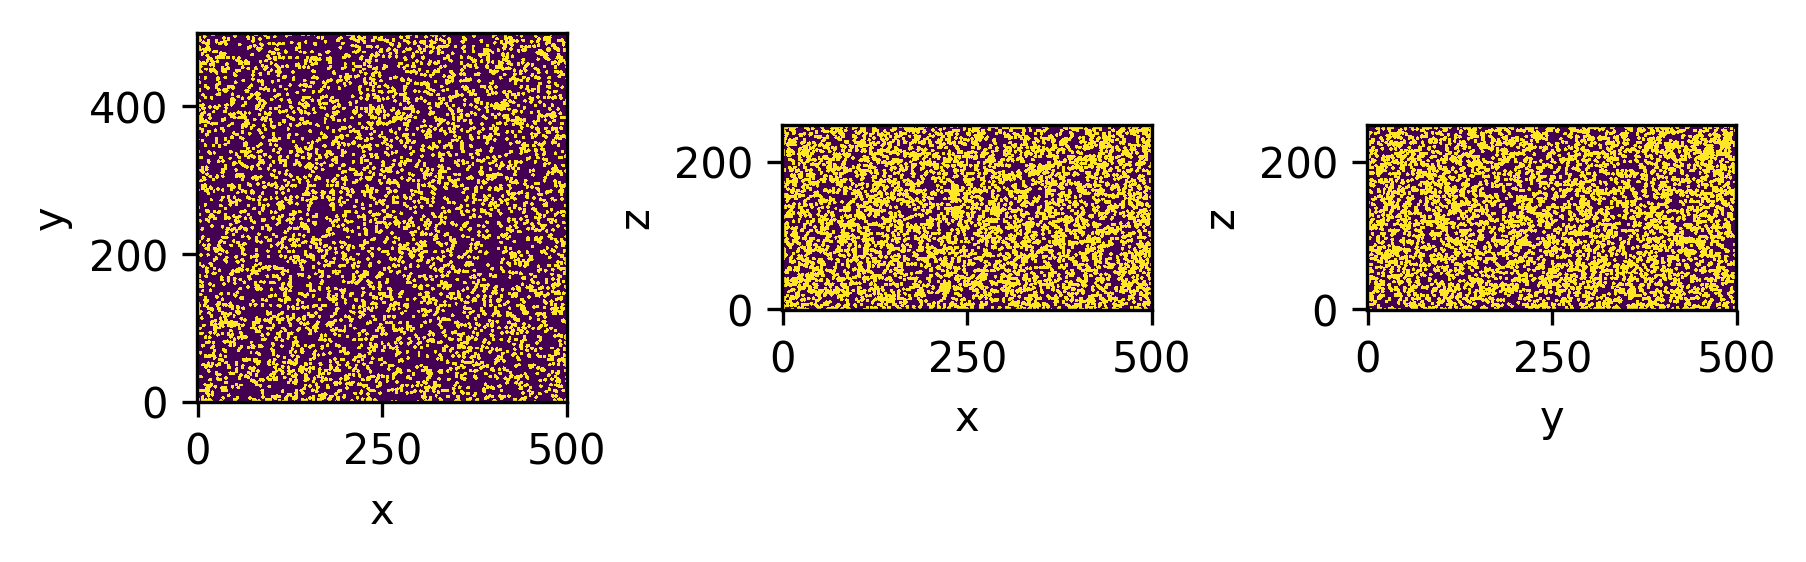

In [24]:
mask = np.copy(S)

treshold = 0.25
print(np.average(X[0]))
indices1 = S > treshold
mask[indices1] = 1
indices2 = S <= treshold
mask[indices2] = 0

#mask[mask >= 0.5] = 1
#mask[mask < 0.5]= 0 
print(mask.shape)
print("average mask {}".format(np.average(mask)))
pyl.maxIntensityProjection(mask)

In [25]:
import skimage
import os
outputPath_tiff_prefix = './test__X_nonIsotropic_production_5000_1_PSNR5_psnr='+str(PSNR)
# this multiplier is necessary so that to prevent all the values being 0 when converting to int

multiplierForOutput = 2**16 #16 bit uint is the max value, so multiply all by that (otherwise you get 0 everywhere when converting to int)

i=0
outputPath_tiff = outputPath_tiff_prefix+str(i).zfill(2)+'.tiff'
skimage.external.tifffile.imsave(outputPath_tiff, (multiplierForOutput*X).astype('uint16'))    
print(os.path.abspath(outputPath_tiff))

multiplierForOutput = 2**8
outputPath_tiff_mask = outputPath_tiff_prefix+"_mask_"+str(i).zfill(2)+'.tiff'
skimage.external.tifffile.imsave(outputPath_tiff_mask, (multiplierForOutput*mask).astype('uint16'))    
print(os.path.abspath(outputPath_tiff_mask))
    


#open the result in chimera X
# volume voxelSize 0.108,0.108,0.2

/Users/johannesschoeneberg/git/JohSchoeneberg/pyLatticeML/src/createSimulatedData/test__X_nonIsotropic_production_5000_1_PSNR5_psnr=20.0672652498562300.tiff
/Users/johannesschoeneberg/git/JohSchoeneberg/pyLatticeML/src/createSimulatedData/test__X_nonIsotropic_production_5000_1_PSNR5_psnr=20.06726524985623_mask_00.tiff
